# Credit card fraud detection


### 📄 Feature Descriptions (Fraud Detection Dataset)

- **trans_date_trans_time**: Timestamp of the transaction (date and time).
- **cc_num**: Unique customer identification number.
- **merchant**: The merchant involved in the transaction.
- **category**: Transaction category type (e.g., personal, childcare).
- **amt**: Transaction amount.
- **first**: First name of the cardholder.
- **last**: Last name of the cardholder.
- **gender**: Gender of the cardholder.
- **street**: Street address of the cardholder.
- **city**: City of residence of the cardholder.
- **state**: State of residence of the cardholder.
- **zip**: ZIP code of the cardholder.
- **lat**: Latitude of the cardholder's location.
- **long**: Longitude of the cardholder's location.
- **city_pop**: Population of the cardholder’s city.
- **job**: Job title of the cardholder.
- **dob**: Date of birth of the cardholder.
- **trans_num**: Unique transaction identifier.
- **unix_time**: Unix timestamp of the transaction.
- **merch_lat**: Latitude of the merchant's location.
- **merch_long**: Longitude of the merchant's location.
- **is_fraud**: Fraud indicator (1 = fraud, 0 = legitimate).




---



>**Note:**  
> If you're running this notebook in [Google Colab](https://colab.research.google.com/), please install the required dependencies by running the cell below.

In [ ]:
# ✅ Install required packages only if running in Colab
import sys
if 'google.colab' in sys.modules:
    !pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost catboost lightgbm feature_engine imbalanced-learn optuna


Otherwise, make sure you've installed all packages listed in `requirements.txt`.

## Environment Setup
### Library Imports


In [ ]:
#  Data Handling
import pandas as pd
import numpy as np

#  Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#  Preprocessing and Machine Learning
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate
)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    make_scorer,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    auc
)

#  Advanced ML Models
from xgboost import XGBClassifier
import xgboost as xgb_module
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#  Feature Engineering
from feature_engine.datetime import DatetimeFeatures
from feature_engine.encoding import (
    CountFrequencyEncoder,
    MeanEncoder,
    RareLabelEncoder,
    OrdinalEncoder
)

#  Class Balancing
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

#  Optimization and Explainability
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances
)
import shap

# Miscellaneous
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from IPython.display import display
import os

In [ ]:
# Mount Google Drive to access project files
from google.colab import drive
drive.mount('/mnt/drive')


Drive already mounted at /mnt/drive; to attempt to forcibly remount, call drive.mount("/mnt/drive", force_remount=True).


In [ ]:
# Change working directory to project folder (adjust path as needed)
import os
folder_path = '/mnt/drive/MyDrive/Full_Data_Projects/Credit_Card_Fraud_Prediction/data'
os.chdir(folder_path)

In [ ]:
# Load dataset (CSV file)
df = pd.read_csv('fraud_test.csv')

In [ ]:
# Preview the dataset
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [ ]:
# Basic dataset info
print(f"Shape: {df.shape}")
df.info()


Shape: (555719, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long            

* The variable `'trans_date_trans_time'` will be transformed into a datetime object
* The variables `'Unnamed: 0'`, `'trans_num'`, and `'cc_num'` are dropped because they do not provide relevant information

In [ ]:
# Drop irrelevant or redundant columns
df.drop(columns=['Unnamed: 0', 'trans_num', 'unix_time'], inplace=True)

## Date Feature

In [ ]:
# Extract datetime features from 'trans_date_trans_time'
from feature_engine.datetime import DatetimeFeatures

dtf = DatetimeFeatures(variables=['trans_date_trans_time'], dayfirst=True)
df = dtf.fit_transform(df)

In [ ]:
# Identify the generated date-related features
date_features = [col for col in df.columns if col.startswith('trans_date_trans_time')]
print(date_features)

['trans_date_trans_time_month', 'trans_date_trans_time_year', 'trans_date_trans_time_day_of_week', 'trans_date_trans_time_day_of_month', 'trans_date_trans_time_hour', 'trans_date_trans_time_minute', 'trans_date_trans_time_second']


Visualized distributions to assess variability.

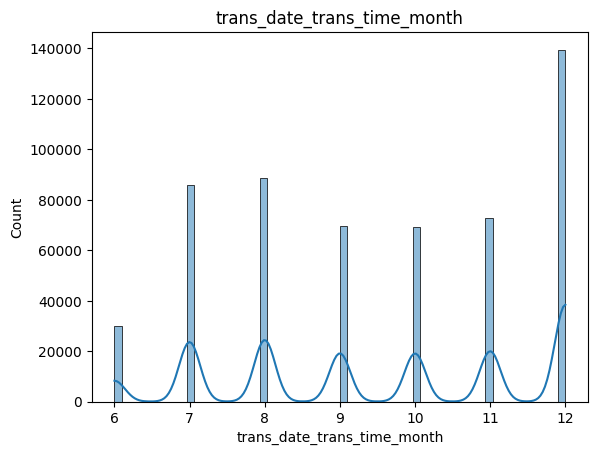

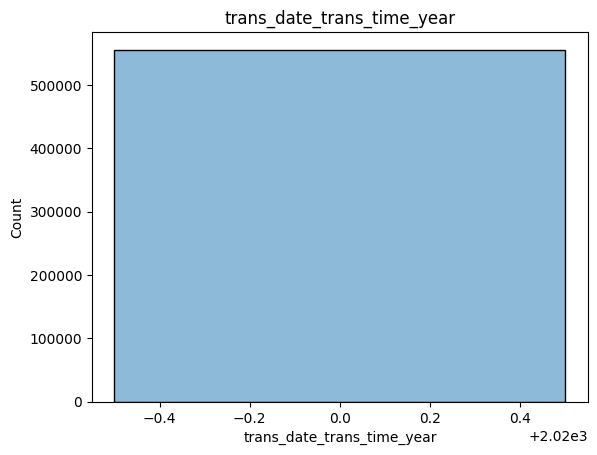

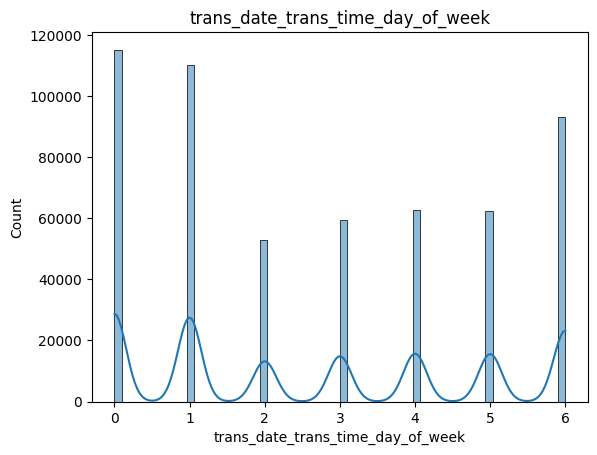

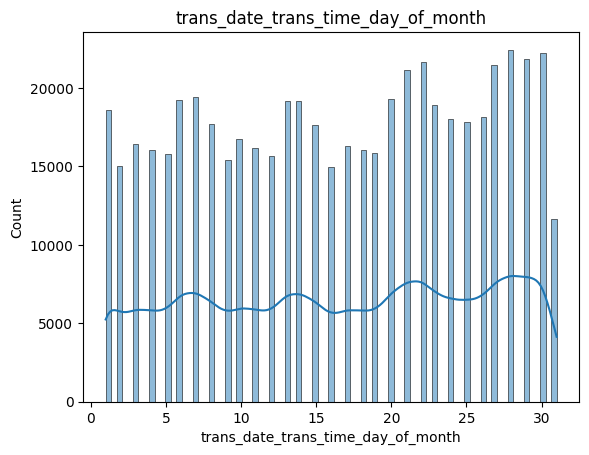

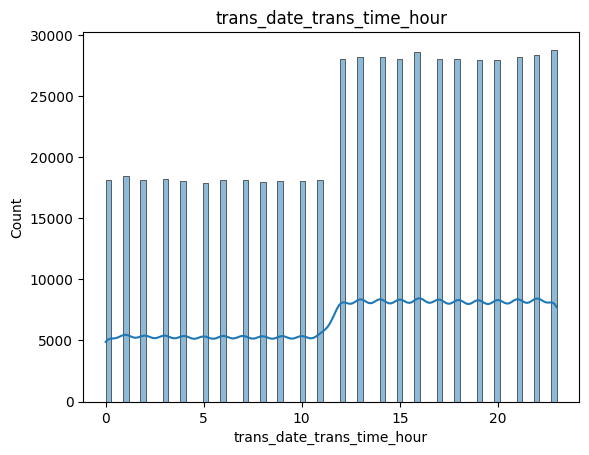

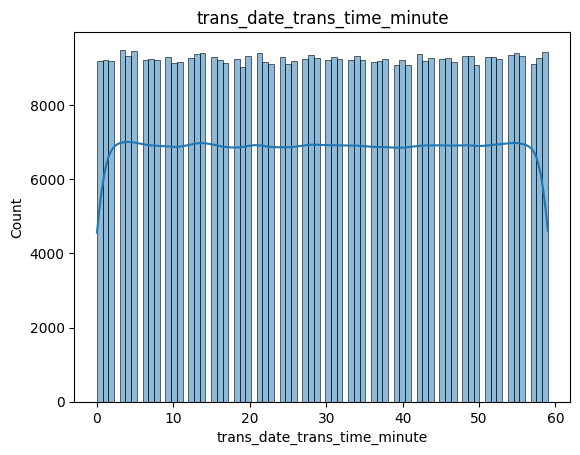

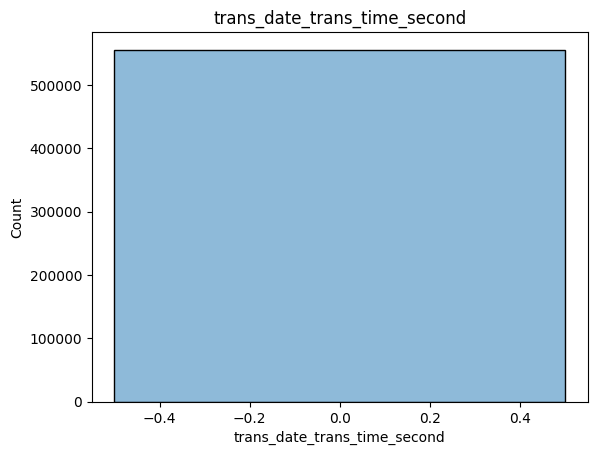

In [ ]:
# Visualize distribution of each date feature
for datef in date_features:
    sns.histplot(df[datef], kde=True)
    plt.title(datef)
    plt.show()

Dropped features with only one unique value (year, second)

In [ ]:
# Remove features with only one unique value
df.drop(['trans_date_trans_time_year', 'trans_date_trans_time_second'], axis = 1, inplace = True)

In [ ]:
# Check column names after transformation
print("Current columns:", df.columns.tolist())

Current columns: ['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat', 'merch_long', 'is_fraud', 'trans_date_trans_time_month', 'trans_date_trans_time_day_of_week', 'trans_date_trans_time_day_of_month', 'trans_date_trans_time_hour', 'trans_date_trans_time_minute']


In [ ]:
# Check for missing values and duplicated rows
print("Missing values per column:\n", df.isna().sum())
print("Duplicated rows:", df.duplicated().sum())

Missing values per column:
 cc_num                                0
merchant                              0
category                              0
amt                                   0
first                                 0
last                                  0
gender                                0
street                                0
city                                  0
state                                 0
zip                                   0
lat                                   0
long                                  0
city_pop                              0
job                                   0
dob                                   0
merch_lat                             0
merch_long                            0
is_fraud                              0
trans_date_trans_time_month           0
trans_date_trans_time_day_of_week     0
trans_date_trans_time_day_of_month    0
trans_date_trans_time_hour            0
trans_date_trans_time_minute          0
dtype: int64

## Categorical Feature Analysis

In [ ]:
# Identify categorical columns
cols_cat = df.select_dtypes(include='object').columns
print("Categorical variables:", list(cols_cat))


Categorical variables: ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob']


In [ ]:
# 2. Frequency of each category (absolute count)
for col in cols_cat:
    print(f"Absolute frequency for: {col}")
    print(df[col].value_counts())
    print('-'*50)


Absolute frequency for: merchant
merchant
fraud_Kilback LLC                        1859
fraud_Cormier LLC                        1597
fraud_Schumm PLC                         1561
fraud_Kuhn LLC                           1521
fraud_Dickinson Ltd                      1519
                                         ... 
fraud_Treutel-King                        323
fraud_Satterfield-Lowe                    319
fraud_Kessler Group                       318
fraud_Jerde-Hermann                       312
fraud_Ritchie, Bradtke and Stiedemann     304
Name: count, Length: 693, dtype: int64
--------------------------------------------------
Absolute frequency for: category
category
gas_transport     56370
grocery_pos       52553
home              52345
shopping_pos      49791
kids_pets         48692
shopping_net      41779
entertainment     40104
personal_care     39327
food_dining       39268
health_fitness    36674
misc_pos          34574
misc_net          27367
grocery_net       19426
travel  

* Se observan proporciones por debajo del 0.5% en la mayoria de las variables categóricas

In [ ]:
# Relative frequency (percentage) of categories
for col in cols_cat:
    print(f"Relative frequency (%) for: {col}")
    print(df[col].value_counts(normalize=True).sort_values(ascending=False) * 100)
    print('-'*50)


Relative frequency (%) for: merchant
merchant
fraud_Kilback LLC                        0.334522
fraud_Cormier LLC                        0.287375
fraud_Schumm PLC                         0.280897
fraud_Kuhn LLC                           0.273699
fraud_Dickinson Ltd                      0.273340
                                           ...   
fraud_Treutel-King                       0.058123
fraud_Satterfield-Lowe                   0.057403
fraud_Kessler Group                      0.057223
fraud_Jerde-Hermann                      0.056143
fraud_Ritchie, Bradtke and Stiedemann    0.054704
Name: proportion, Length: 693, dtype: float64
--------------------------------------------------
Relative frequency (%) for: category
category
gas_transport     10.143616
grocery_pos        9.456758
home               9.419329
shopping_pos       8.959744
kids_pets          8.761982
shopping_net       7.518008
entertainment      7.216597
personal_care      7.076778
food_dining        7.066161
health_fi

* Variables con alta cardinalidad: merchant, first, last, street, city, job
* Convertir dob en edad

In [ ]:
# Cardinality check: number of unique labels per categorical variable
for var in cols_cat:
    print(f"{var} contains {df[var].nunique()} unique labels")


merchant contains 693 unique labels
category contains 14 unique labels
first contains 341 unique labels
last contains 471 unique labels
gender contains 2 unique labels
street contains 924 unique labels
city contains 849 unique labels
state contains 50 unique labels
job contains 478 unique labels
dob contains 910 unique labels


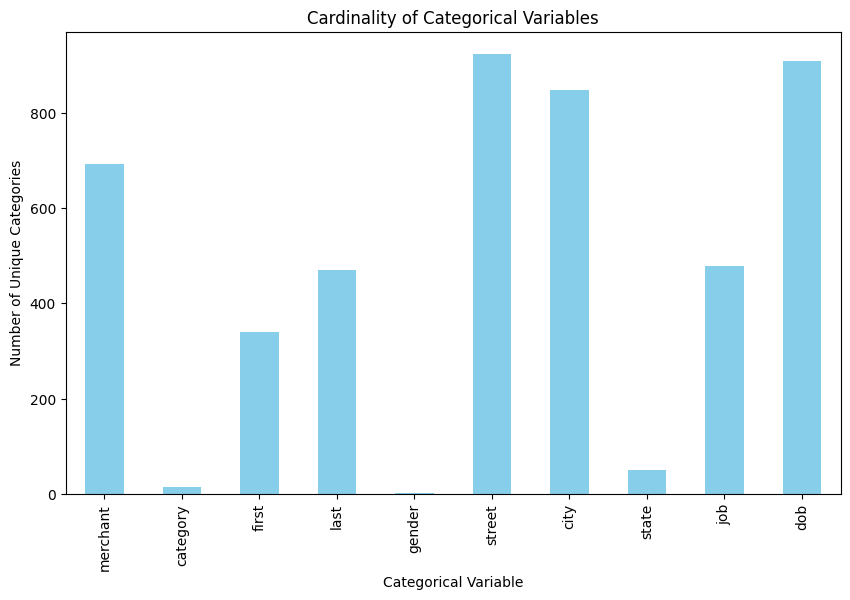

In [ ]:
# Visualize cardinality
df[cols_cat].nunique().plot.bar(figsize=(10,6), color="skyblue")
plt.title('Cardinality of Categorical Variables')
plt.xlabel('Categorical Variable')
plt.ylabel('Number of Unique Categories')
plt.show()

In [ ]:
# 6. Drop high cardinality columns (which can add noise)
df.drop(columns=['merchant', 'first', 'last', 'street', 'city', 'job'], inplace=True)


In [ ]:
# 7. Custom fraud rate plot function
def plot_fraud_category(df, category_col, top_n=10):
    total_counts = df[category_col].value_counts()
    fraud_counts = df[df['is_fraud'] == 1][category_col].value_counts()

    fraud_rate = (fraud_counts / total_counts) * 100
    fraud_rate = fraud_rate.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(12,6))
    sns.barplot(x=fraud_rate.index, y=fraud_rate.values, palette='Reds_r')
    plt.title(f'Fraud Rate by {category_col} (Top {top_n})', fontsize=14)
    plt.xlabel(category_col, fontsize=12)
    plt.ylabel('Fraud Rate (%)', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()


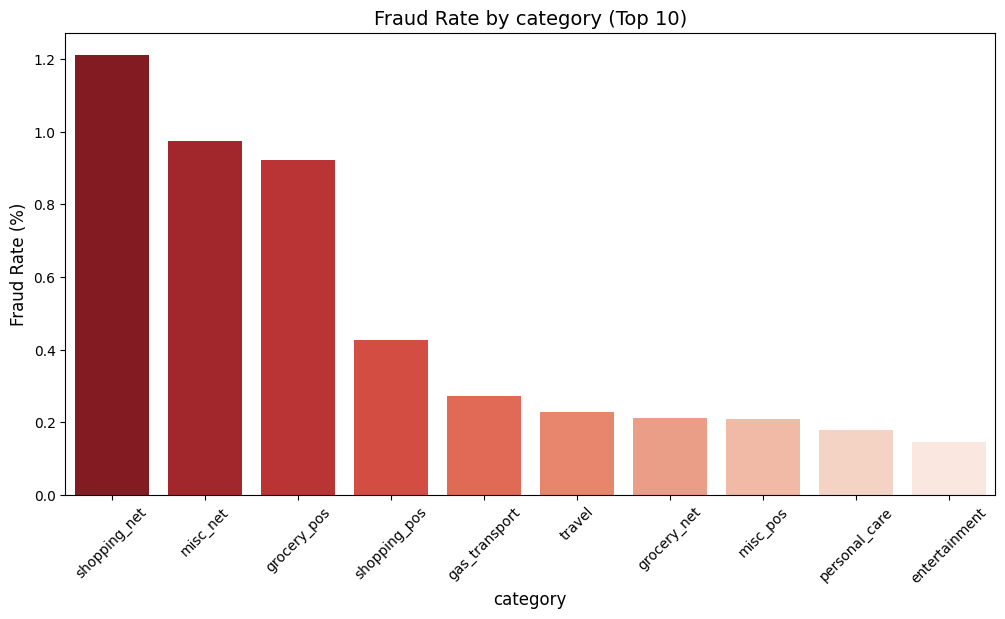

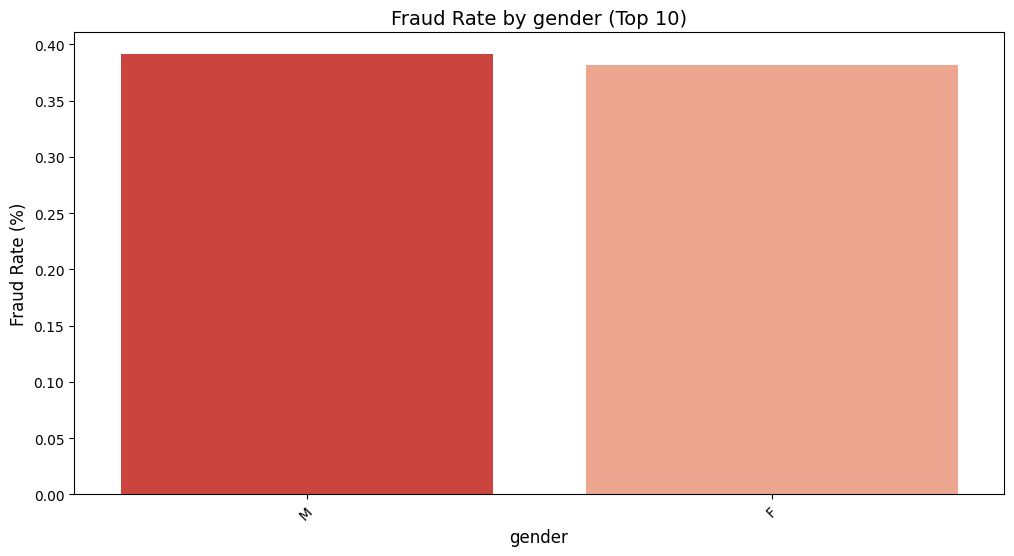

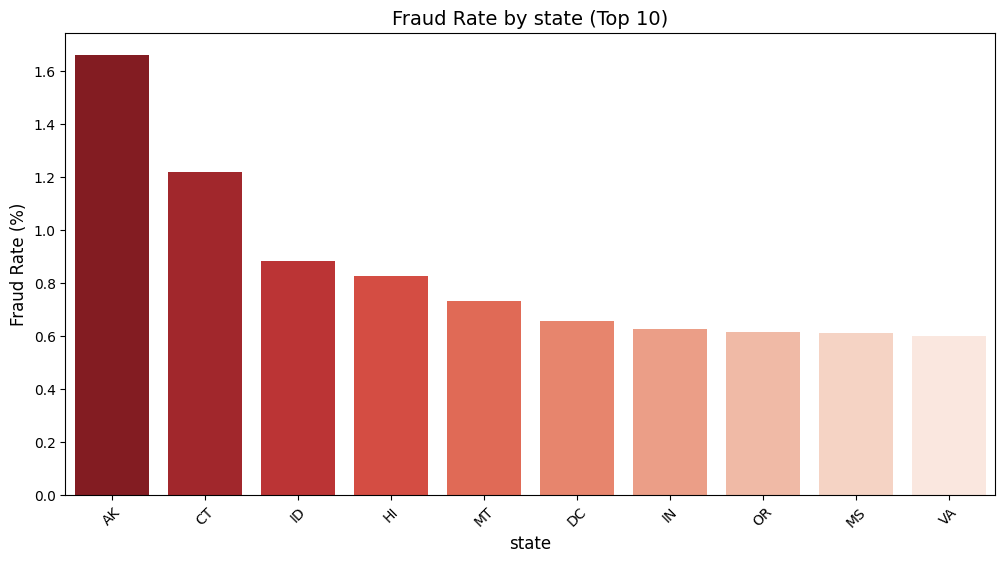

In [ ]:
# 8. Apply fraud analysis per category
plot_fraud_category(df, 'category', top_n=10)
plot_fraud_category(df, 'gender')
plot_fraud_category(df, 'state', top_n=10)


- The categories 'shopping_net', 'grocery_pos', and 'misc_net' show the highest fraud rates.
-  No significant difference in fraud risk between genders.
- States like AK, CT, and ID show the highest fraud proportions, ranging from 0.9% to 1.6%, with Alaska leading.

## Memory Usage Analysis

In [ ]:
# Calculate memory usage per column (including string objects)
memory = df.memory_usage(deep = True)
memory

,0
Index,132
cc_num,4445752
category,37525219
amt,4445752
gender,32231702
state,32787421
zip,4445752
lat,4445752
long,4445752
city_pop,4445752


In [ ]:
# Convert total memory to gigabytes
memory.sum() / (1024 ** 3)

np.float64(0.17779301386326551)

- Memory usage analysis revealed that object-type columns such as category, gender, and state were the most memory-consuming. The dataset occupied approximately 0.18 GB in memory.

In [ ]:
# Convert 'dob' column to datetime formatdf['dob'] = pd.to_datetime(df['dob'])
df['dob'] = pd.to_datetime(df['dob'])

In [ ]:
# Calculate age from year of birth
current_year = datetime.now().year
df['age'] = current_year - df['dob'].dt.year

In [ ]:
# Display min and max age
print(f'Edad mínima: {df["age"].min()}')
print(f'Edad máxima: {df["age"].max()}')

Edad mínima: 20
Edad máxima: 101


In [ ]:
# Handle outliers using IQR method
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

# Remove rows with age outside normal range
df = df[(df['age'] <= upper_limit) & (df['age'] >= lower_limit)]

# Confirm new age range after outlier removal
print(f"New max age: {df['age'].max()}")

New max age: 99


dob: 909
age_range: 6


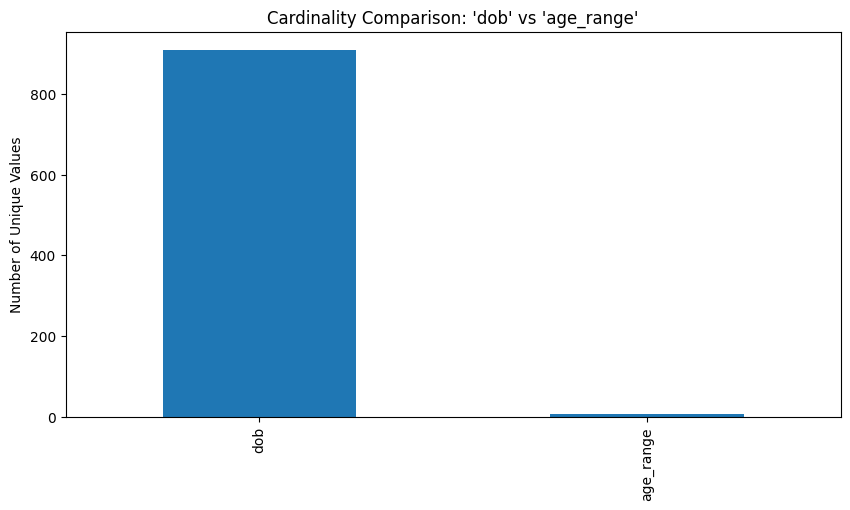

In [ ]:
# Define age bins and labels
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Create 'age_range' column based on bins
df['age_range'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

# Drop the intermediate 'age' column
df.drop(columns='age', inplace=True)

# Compare cardinality of 'dob' vs 'age_range'
print(f'dob: {df["dob"].nunique()}')
print(f'age_range: {df["age_range"].nunique()}')

# Visualize reduction in cardinality
df[['dob', 'age_range']].nunique().plot.bar(figsize=(10,5))
plt.title("Cardinality Comparison: 'dob' vs 'age_range'")
plt.ylabel("Number of Unique Values")
plt.show()

* Se ha reducido considerablemente la cardinalidad para la variable "dob"

In [ ]:
# Drop 'dob' for privacy and redundancy
df.drop(columns='dob',inplace=True)

# Preview final result
df.head()

,cc_num,category,amt,gender,state,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,trans_date_trans_time_month,trans_date_trans_time_day_of_week,trans_date_trans_time_day_of_month,trans_date_trans_time_hour,trans_date_trans_time_minute,age_range
0,2.291160e+15,personal_care,2.86,M,SC,29209,33.9659,-80.9355,333497,33.986391,-81.200714,0,6,6,21,12,14,55-64
1,3.573030e+15,personal_care,29.84,F,UT,84002,40.3207,-110.4360,302,39.450498,-109.960431,0,6,6,21,12,14,25-34
2,3.598220e+15,health_fitness,41.28,F,NY,11710,40.6729,-73.5365,34496,40.495810,-74.196111,0,6,6,21,12,14,45-54
3,3.591920e+15,misc_pos,60.05,M,FL,32780,28.5697,-80.8191,54767,28.812398,-80.883061,0,6,6,21,12,15,35-44
4,3.526830e+15,travel,3.19,M,MI,49632,44.2529,-85.0170,1126,44.959148,-85.884734,0,6,6,21,12,15,65+


- Date of birth was converted to age and further binned into age groups. Outliers were removed using the IQR rule. The original dob column was dropped to reduce cardinality and preserve privacy.

## Numerical Features

In [ ]:
# Descriptive statistics of numerical features
df.describe()

,cc_num,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,trans_date_trans_time_month,trans_date_trans_time_day_of_week,trans_date_trans_time_day_of_month,trans_date_trans_time_hour,trans_date_trans_time_minute
count,5.555200e+05,555520.000000,555520.000000,555520.000000,555520.000000,5.555200e+05,555520.000000,555520.000000,555520.000000,555520.000000,555520.000000,555520.000000,555520.000000,555520.000000
mean,4.179876e+17,69.387217,48852.569643,38.543014,-90.236184,8.824999e+04,38.542544,-90.236233,0.003849,9.508518,2.726779,16.463645,12.809789,29.501820
std,1.310048e+18,156.734872,26854.954665,5.062227,13.721835,3.004410e+05,5.096715,13.733132,0.061918,1.978216,2.178671,8.955278,6.810716,17.340704
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,19.027422,-166.671575,0.000000,6.000000,0.000000,1.000000,0.000000,0.000000
25%,1.800430e+14,9.630000,26292.000000,34.668900,-96.809400,7.410000e+02,34.753488,-96.908181,0.000000,8.000000,1.000000,9.000000,7.000000,14.000000
50%,3.521420e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,39.376919,-87.450517,0.000000,10.000000,2.000000,17.000000,14.000000,29.000000
75%,4.642260e+15,83.010000,72042.000000,41.894800,-80.175200,1.968500e+04,41.955313,-80.272017,0.000000,12.000000,5.000000,24.000000,19.000000,45.000000
max,4.992350e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,66.679297,-66.952026,1.000000,12.000000,6.000000,31.000000,23.000000,59.000000


In [ ]:
# Identify numerical columns (excluding datetime features)
cols_num = df.select_dtypes(include=np.number).columns
filtered_cols = [col for col in cols_num if not col.startswith('trans_date_trans')]

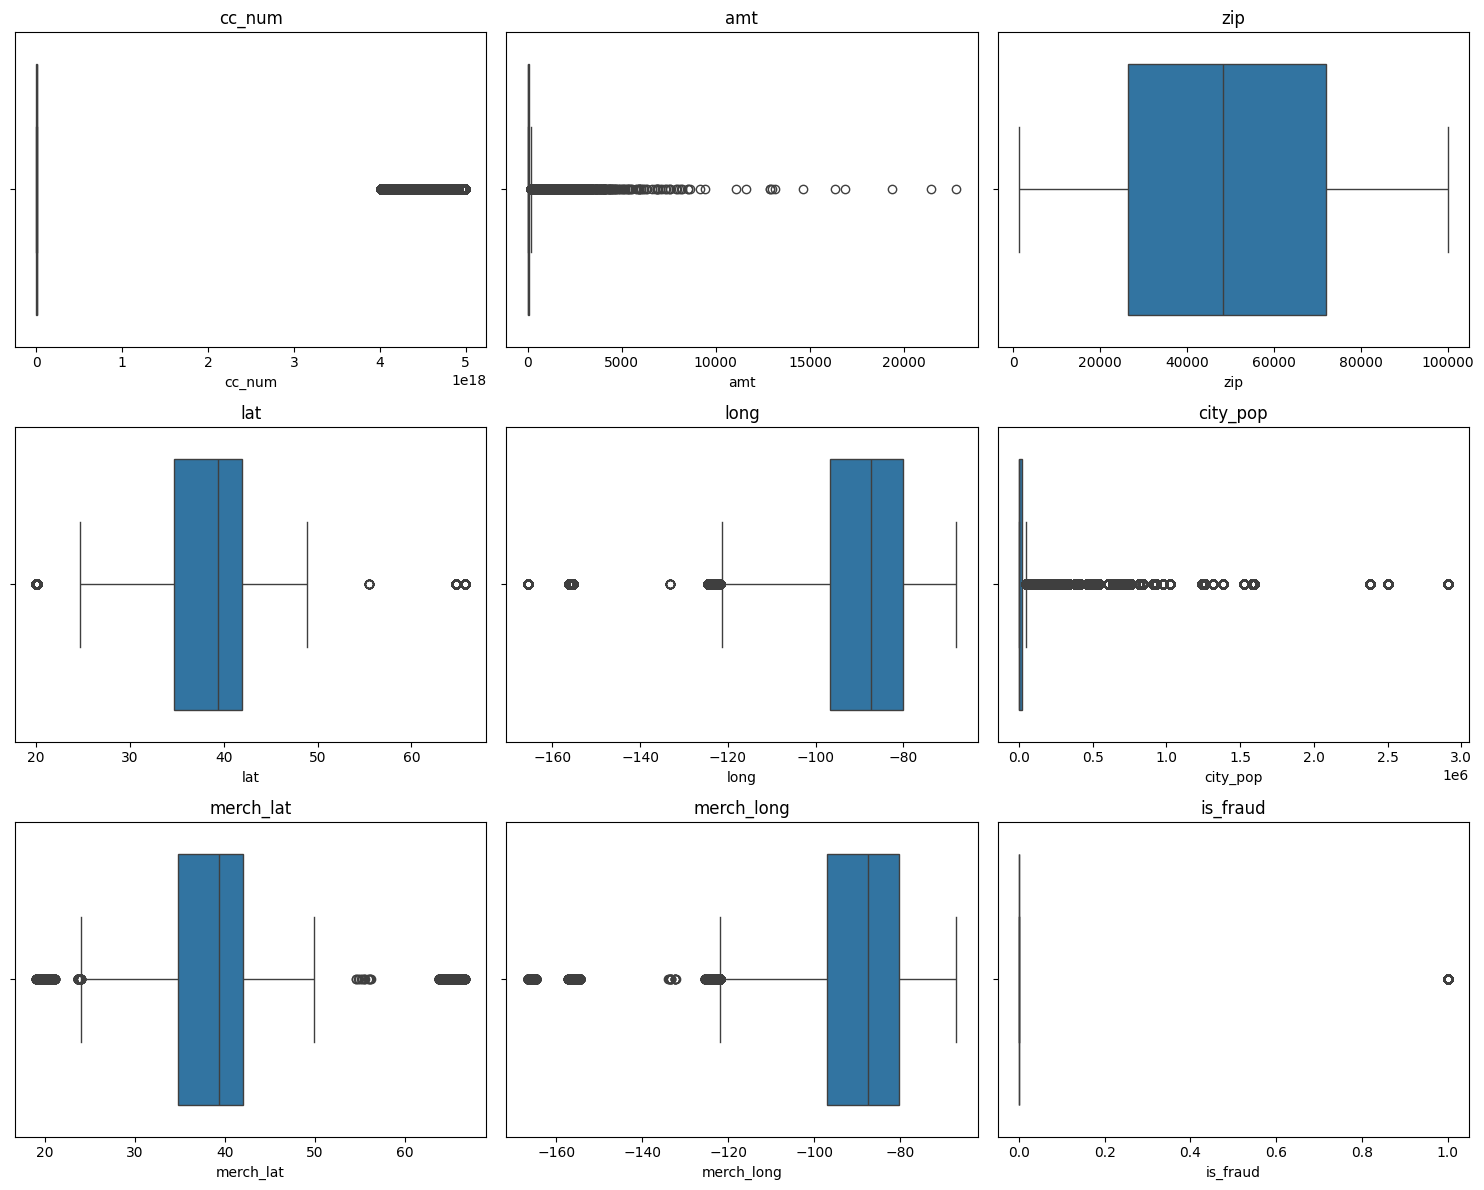

In [ ]:
# Boxplot distribution of each numerical variable
n_cols = 3
n_rows = (len(filtered_cols) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axs = axs.flatten()

for i, col in enumerate(filtered_cols):
    sns.boxplot(x=df[col], ax=axs[i])
    axs[i].set_title(col)

# Remove empty axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()



In [ ]:
# Detailed distribution of 'amt'
print(df['amt'].describe())
print(df.groupby('is_fraud')['amt'].describe())

count    555520.000000
mean         69.387217
std         156.734872
min           1.000000
25%           9.630000
50%          47.290000
75%          83.010000
max       22768.110000
Name: amt, dtype: float64
             count        mean         std   min     25%      50%      75%  \
is_fraud                                                                     
0         553382.0   67.613512  152.474730  1.00    9.60   47.145   82.620   
1           2138.0  528.478036  392.442979  1.78  216.07  372.295  906.845   

               max  
is_fraud            
0         22768.11  
1          1320.92  


- Most fraudulent transactions occur with amounts above 216.07 (25th percentile).
- Non-fraudulent transactions can be extremely large (up to 22,768), but fraud rarely exceeds 1,320.

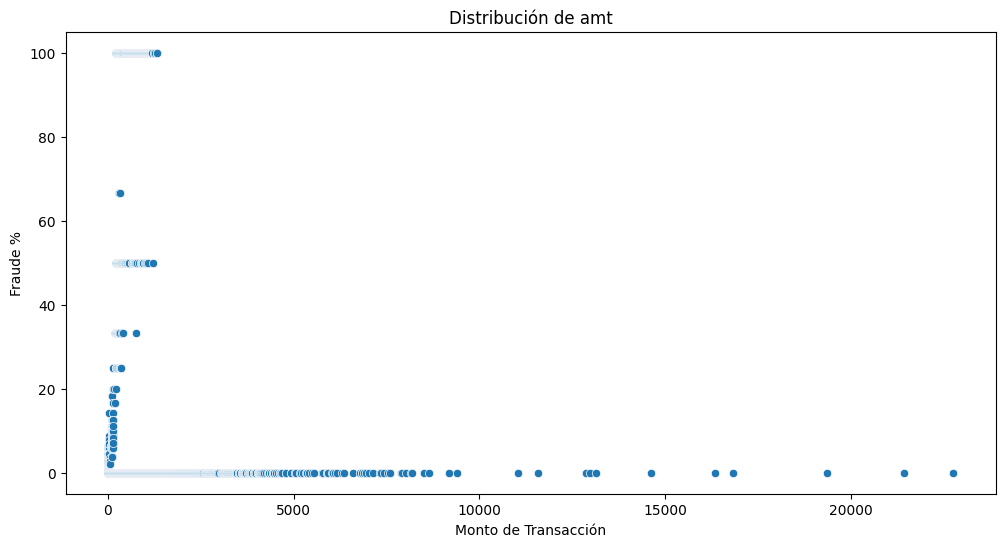

In [ ]:
# Visualize fraud rate by transaction amount
group = df.groupby('amt')['is_fraud'].mean().mul(100).reset_index()
plt.figure(figsize=(12,6))
sns.scatterplot(x='amt', y='is_fraud', data=group)
plt.title('Distribución de amt')
plt.xlabel('Monto de Transacción')
plt.ylabel('Fraude %')
plt.show()


In [ ]:
# Log transformation of 'amt'
df['log_amt'] = np.log1p(df['amt'])

In [ ]:
# Cap outliers in class 0 (legit transactions) at 99th percentile
q99 = df[df['is_fraud'] == 0]['amt'].quantile(0.99)
df.loc[(df['is_fraud'] == 0) & (df['amt'] > q99), 'amt'] = q99

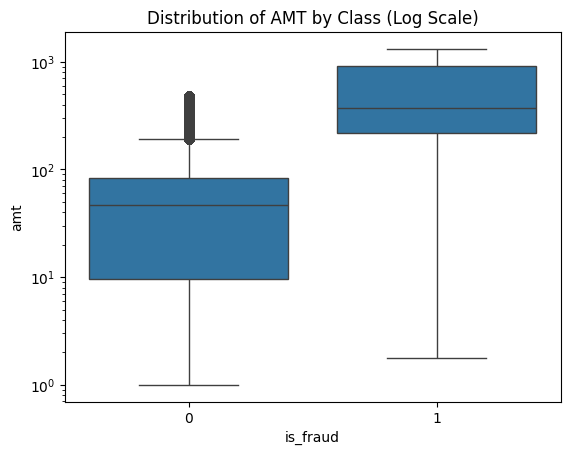

In [ ]:
# Boxplot of amt after treatment (log scale)
sns.boxplot(x='is_fraud', y='amt', data=df)
plt.yscale('log')
plt.title('Distribution of AMT by Class (Log Scale)')
plt.show()

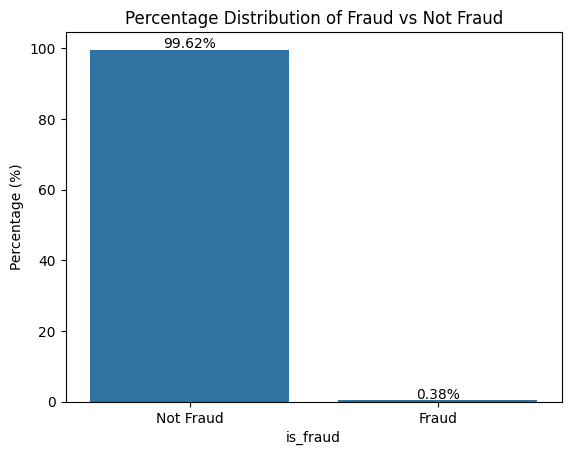

In [ ]:
# Check target variable imbalance
total = len(df)
percentages = df['is_fraud'].value_counts(normalize=True) * 100

sns.barplot(x=percentages.index, y=percentages.values)
plt.xticks(ticks=[0, 1], labels=['Not Fraud', 'Fraud'])
plt.ylabel('Percentage (%)')

for i, pct in enumerate(percentages.values):
    plt.text(i, pct + 0.5, f'{pct:.2f}%', ha='center')

plt.title('Percentage Distribution of Fraud vs Not Fraud')
plt.show()


- The dataset is highly imbalanced. Fraud represents less than 0.5% of the total data.
This will be addressed in the model training phase with appropriate techniques (e.g., SMOTE).

In [ ]:
# Correlation matrix between numerical features
cols_num = [col for col in cols_num]
correlation = df[cols_num].corr()
correlation

,cc_num,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,trans_date_trans_time_month,trans_date_trans_time_day_of_week,trans_date_trans_time_day_of_month,trans_date_trans_time_hour,trans_date_trans_time_minute
cc_num,1.000000,0.002884,0.041501,-0.057499,-0.048680,-0.009444,-0.057169,-0.048715,-0.001485,-0.000539,0.003032,-0.001726,-0.001172,-0.000878
amt,0.002884,1.000000,0.004883,0.005043,-0.003993,0.002871,0.005141,-0.004001,0.347253,-0.002404,0.006119,-0.003784,-0.072401,-0.001450
zip,0.041501,0.004883,1.000000,-0.115147,-0.909909,0.075490,-0.114780,-0.909085,-0.002088,0.001411,-0.000075,-0.000138,0.005858,0.000717
lat,-0.057499,0.005043,-0.115147,1.000000,-0.012941,-0.152656,0.993559,-0.012880,0.005849,0.000685,0.001093,-0.002301,-0.010664,-0.000782
long,-0.048680,-0.003993,-0.909909,-0.012941,1.000000,-0.051441,-0.012603,0.999115,-0.001153,-0.001520,0.000099,0.000306,-0.001490,-0.000128
city_pop,-0.009444,0.002871,0.075490,-0.152656,-0.051441,1.000000,-0.151692,-0.051406,-0.004870,-0.001115,-0.002010,0.001946,0.018913,0.000398
merch_lat,-0.057169,0.005141,-0.114780,0.993559,-0.012603,-0.151692,1.000000,-0.012547,0.005797,0.000750,0.001196,-0.002304,-0.010497,-0.000949
merch_long,-0.048715,-0.004001,-0.909085,-0.012880,0.999115,-0.051406,-0.012547,1.000000,-0.001238,-0.001537,0.000075,0.000248,-0.001535,-0.000222
is_fraud,-0.001485,0.347253,-0.002088,0.005849,-0.001153,-0.004870,0.005797,-0.001238,1.000000,-0.011613,0.009623,-0.008916,0.011682,-0.002102
trans_date_trans_time_month,-0.000539,-0.002404,0.001411,0.000685,-0.001520,-0.001115,0.000750,-0.001537,-0.011613,1.000000,-0.004127,-0.104075,-0.005046,-0.001207


- Analyzed numerical features using descriptive statistics, boxplots, and class-specific distributions. Identified and handled outliers in the amt feature. Applied log transformation and capped values for legitimate transactions. Strong imbalance in the target variable was identified, to be addressed later using class balancing techniques

## Feature Selection

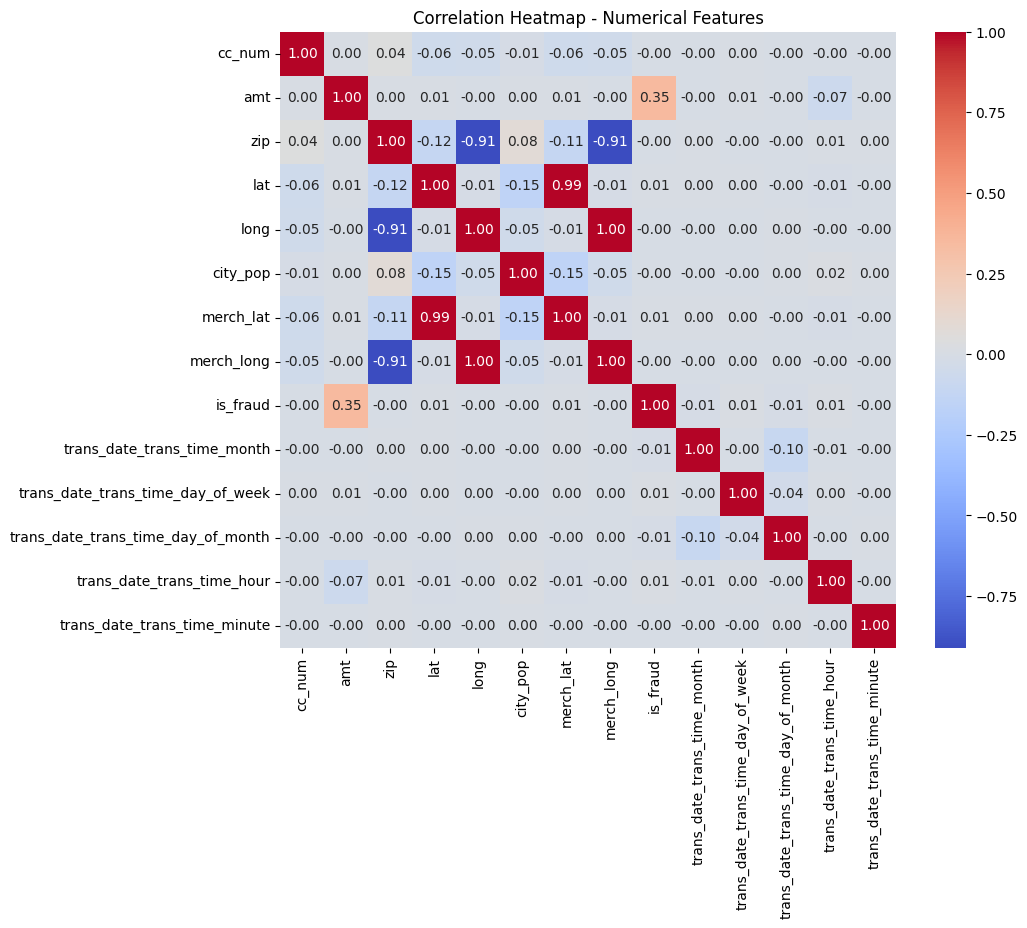

In [ ]:
# Visualize numerical correlation matrix
plt.figure(figsize=(10,8))
plt.title('Correlation Heatmap - Numerical Features')
sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white', cmap='coolwarm')
plt.xticks(rotation=90)
plt.show()

- High correlation detected between:
    * 'lat' and 'merch_lat'
    * 'long' and 'merch_long'
    * 'zip' and 'long'/'merch_long'
- This may lead to redundancy and multicollinearity in models.

<Figure size 800x400 with 0 Axes>

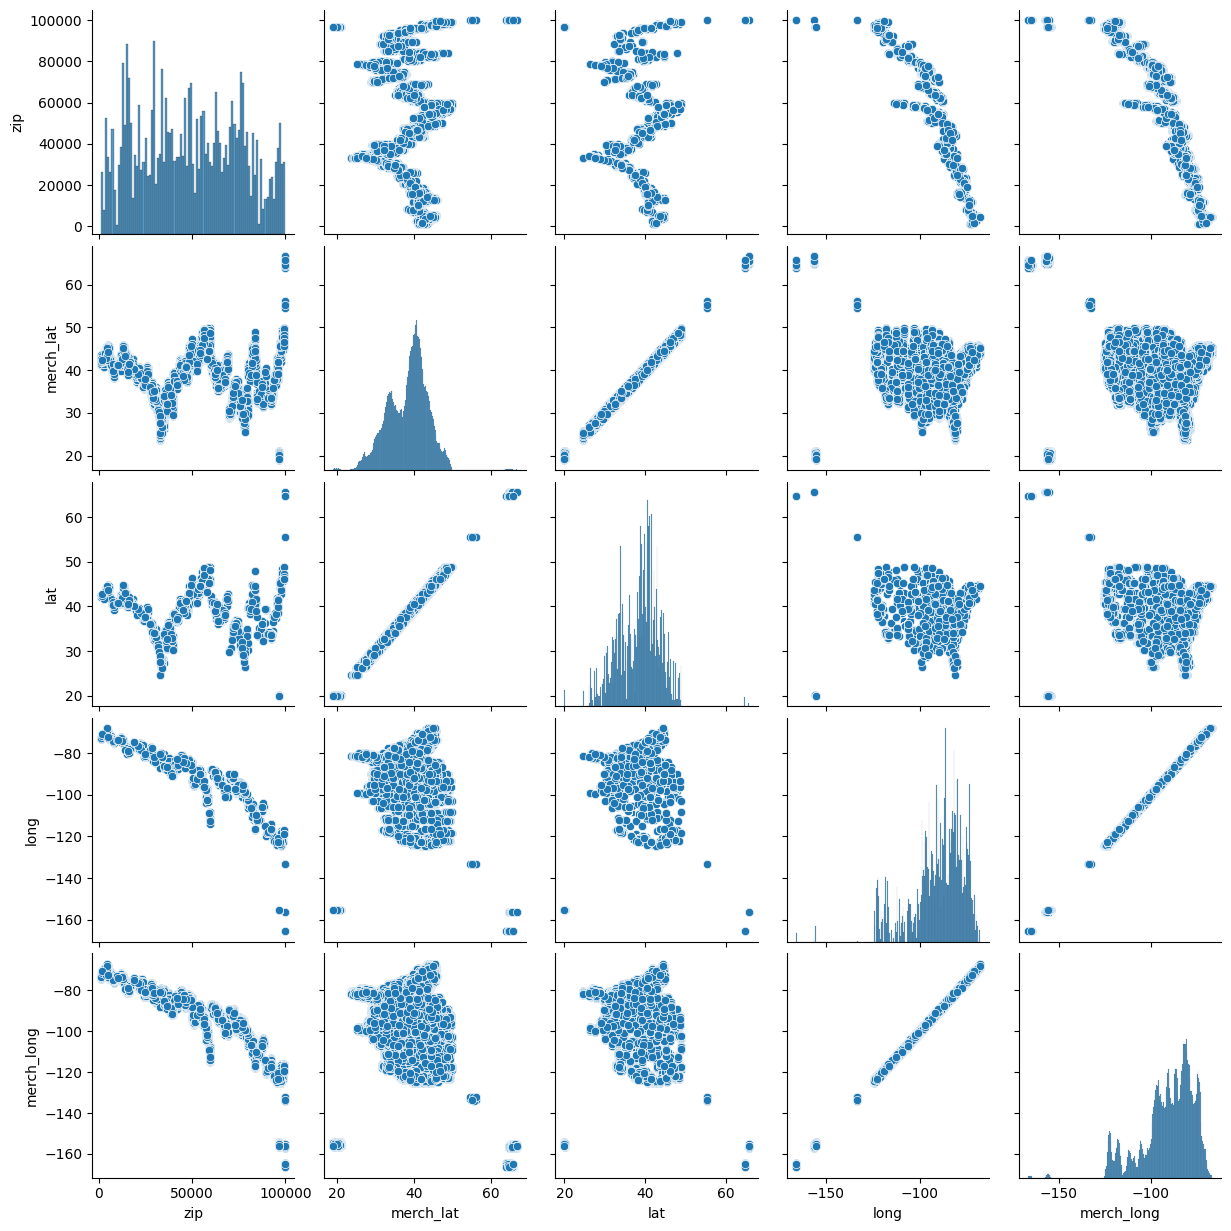

In [ ]:
# Visual inspection
num_var = ['zip', 'merch_lat', 'lat', 'long', 'merch_long']
plt.figure(figsize=(8,4))
sns.pairplot(df[num_var], kind='scatter', diag_kind='hist')
plt.show();

In [ ]:
# Variance of correlated features
print("Variance comparison:")
print(df[['merch_lat', 'lat']].var())
print('*'*30)
print(df[['zip', 'merch_long', 'long']].var())

Variance comparison:
merch_lat    25.976499
lat          25.626142
dtype: float64
******************************
zip           7.211886e+08
merch_long    1.885989e+02
long          1.882888e+02
dtype: float64


- Keeping 'merch_lat' and 'zip' as representative features
Dropping 'lat', 'long', and 'merch_long' to reduce redundancy

In [ ]:
# Drop highly correlated variables
df.drop(columns=['lat', 'long', 'merch_long'], inplace=True)

In [ ]:
# Convert 'object' type variables to 'category' to save memory and assist model
cat_features = df.select_dtypes(include='object').columns
for feature in cat_features:
    if feature != 'trans_date_trans_time':  # Already transformed
        df[feature] = df[feature].astype('category')

In [ ]:
# Move target variable 'is_fraud' to the end of the dataframe
target = df['is_fraud']
df.drop(columns='is_fraud', inplace=True)
df['is_fraud'] = target

In [ ]:
# Final check
print(df.dtypes)
print('*'*80)
print(df.columns)
print('*'*80)
df.head()

cc_num                                 float64
category                              category
amt                                    float64
gender                                category
state                                 category
zip                                      int64
city_pop                                 int64
merch_lat                              float64
trans_date_trans_time_month              int32
trans_date_trans_time_day_of_week        int32
trans_date_trans_time_day_of_month       int32
trans_date_trans_time_hour               int32
trans_date_trans_time_minute             int32
age_range                             category
log_amt                                float64
is_fraud                                 int64
dtype: object
********************************************************************************
Index(['cc_num', 'category', 'amt', 'gender', 'state', 'zip', 'city_pop',
       'merch_lat', 'trans_date_trans_time_month',
       'trans_date_trans_tim

,cc_num,category,amt,gender,state,zip,city_pop,merch_lat,trans_date_trans_time_month,trans_date_trans_time_day_of_week,trans_date_trans_time_day_of_month,trans_date_trans_time_hour,trans_date_trans_time_minute,age_range,log_amt,is_fraud
0,2.291160e+15,personal_care,2.86,M,SC,29209,333497,33.986391,6,6,21,12,14,55-64,1.350667,0
1,3.573030e+15,personal_care,29.84,F,UT,84002,302,39.450498,6,6,21,12,14,25-34,3.428813,0
2,3.598220e+15,health_fitness,41.28,F,NY,11710,34496,40.495810,6,6,21,12,14,45-54,3.744314,0
3,3.591920e+15,misc_pos,60.05,M,FL,32780,54767,28.812398,6,6,21,12,15,35-44,4.111693,0
4,3.526830e+15,travel,3.19,M,MI,49632,1126,44.959148,6,6,21,12,15,65+,1.432701,0


- We removed redundant features based on correlation and variance analysis. `zip` and `merch_lat` were retained while `lat`, `long`, and `merch_long were` dropped due to high collinearity. Object-type features were converted to categorical types to optimize memory usage and improve model compatibility.

## Model Training and Evaluation

In [ ]:
# Split dataset into features (X) and target (y)
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# Split data into 70% training and 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split temp into 50% validation and 50% test (i.e., 15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,stratify=y_temp)

# Check split sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 388864
Validation set size: 83328
Test set size: 83328


## Feature Encoding Pipeline

In [ ]:
encoding_pipe = Pipeline([
        ('Frequency', CountFrequencyEncoder(encoding_method='frequency', variables=['category'], unseen='encode')),
        ('Mean', MeanEncoder(variables=['gender'], unseen='encode')),
        ('Rare', RareLabelEncoder(variables=['state'])),
        ('Ordinal_state', OrdinalEncoder(encoding_method='ordered', variables=['state'], unseen='encode')),
        ('Ordinal_age', OrdinalEncoder(encoding_method='ordered', variables=['age_range'], unseen='encode'))
    ])

In [ ]:
# Fit and transform datasets
X_train = encoding_pipe.fit_transform(X_train, y_train)
X_val = encoding_pipe.fit_transform(X_val, y_val)
X_test = encoding_pipe.transform(X_test)

## Model Evaluation via Cross-Validation

In [ ]:
# Define evaluation metrics
scoring = {
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc',
    'pr_auc': make_scorer(average_precision_score)
}

# Use Stratified K-Fold to maintain class balance in folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate baseline models
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(max_iter=100, random_state=42)

# Evaluate models using cross-validation
xgb_cv = cross_validate(xgb, X_train, y_train, cv=cv, scoring=scoring)
cat_cv = cross_validate(cat, X_train, y_train, cv=cv, scoring=scoring)
rf_cv = cross_validate(rf, X_train, y_train, cv=cv, scoring=scoring)
lr_cv = cross_validate(lr, X_train, y_train, cv=cv, scoring=scoring)

# Aggregate results into DataFrame
results = pd.DataFrame({
    'Model': ['XGBoost', 'CatBoost', 'RandomForest', 'Logistic Regression'],
    'F1-score': [xgb_cv['test_f1'].mean(), cat_cv['test_f1'].mean(), rf_cv['test_f1'].mean(), lr_cv['test_f1'].mean()],
    'PR-AUC': [xgb_cv['test_pr_auc'].mean(), cat_cv['test_pr_auc'].mean(), rf_cv['test_pr_auc'].mean(), lr_cv['test_pr_auc'].mean()],
    'ROC-AUC': [xgb_cv['test_roc_auc'].mean(), cat_cv['test_roc_auc'].mean(), rf_cv['test_roc_auc'].mean(), lr_cv['test_roc_auc'].mean()],
    'Recall': [xgb_cv['test_recall'].mean(), cat_cv['test_recall'].mean(), rf_cv['test_recall'].mean(), lr_cv['test_recall'].mean()],
    'Precision': [xgb_cv['test_precision'].mean(), cat_cv['test_precision'].mean(), rf_cv['test_precision'].mean(), lr_cv['test_precision'].mean()]

})

print(results)


                 Model  F1-score    PR-AUC   ROC-AUC    Recall  Precision
0              XGBoost  0.866651  0.759650  0.997560  0.788227   0.962439
1             CatBoost  0.893160  0.805280  0.996321  0.819616   0.981696
2         RandomForest  0.864323  0.761112  0.981530  0.764841   0.993921
3  Logistic Regression  0.000000  0.003850  0.534408  0.000000   0.000000


- Model selected: CatBoost (best balance between F1, PR-AUC and Precision)

Verificación de Overfitting/Underfitting, con DMatix, ya que sin DMatrix no puedo usar `early_stopping_rounds`

##  Function to Evaluate Overfitting via Stratified K-Fold CV

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score
import numpy as np

def train_evaluate_model(X_train, y_train, params=None, n_splits=5, early_stopping_rounds=50):
    '''
    Evaluates a CatBoostClassifier using stratified K-fold cross-validation.

    Parameters:
        - X_train (pd.DataFrame): Training features
        - y_train (pd.Series): Training labels
        - params (dict): Optional hyperparameters for CatBoost
        - n_splits (int): Number of folds for cross-validation
        - early_stopping_rounds (int): Early stopping to prevent overfitting

    Returns:
        Mean scores for PR-AUC and F1 on training and validation sets
    '''

    train_pr_auc_scores = []
    val_pr_auc_scores = []
    train_f1_scores = []
    val_f1_scores = []

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in cv.split(X_train, y_train):
        # Split into training and validation folds
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Initialize CatBoost model
        model = CatBoostClassifier(
            eval_metric='Logloss',
            iterations=1000,
            early_stopping_rounds=early_stopping_rounds,
            random_state=42,
            use_best_model=True,
            verbose=0,
            **(params or {})
        )

        # Train the model
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val))

        # Predict probabilities and classes
        y_tr_pred_prob = model.predict_proba(X_tr)[:, 1]
        y_val_pred_prob = model.predict_proba(X_val)[:, 1]
        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        # Métricas
        train_pr_auc = average_precision_score(y_tr, y_tr_pred_prob)
        val_pr_auc = average_precision_score(y_val, y_val_pred_prob)
        train_f1 = f1_score(y_tr, y_tr_pred)
        val_f1 = f1_score(y_val, y_val_pred)

        # Compute metrics
        train_pr_auc_scores.append(train_pr_auc)
        val_pr_auc_scores.append(val_pr_auc)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

    # Return average metrics
    return {
        'train_pr_auc': np.mean(train_pr_auc_scores),
        'val_pr_auc': np.mean(val_pr_auc_scores),
        'train_f1': np.mean(train_f1_scores),
        'val_f1': np.mean(val_f1_scores)
    }


- A custom function was developed to systematically evaluate the presence of overfitting across models using stratified K-fold cross-validation. This included tracking performance with PR-AUC and F1-score on both training and validation folds with early stopping to avoid unnecessary learning on noise.

In [ ]:
# Baseline Hyperparameters (No Regularization)
params_baseline = {
    'loss_function': 'Logloss',
}

In [ ]:
results_baseline = train_evaluate_model(X_train, y_train, params_baseline)

print("Baseline Model Evaluation")
print(f"PR-AUC promedio en TRAIN: {results_baseline['train_pr_auc']:.5f}")
print(f"PR-AUC promedio en VALIDACIÓN: {results_baseline['val_pr_auc']:.5f}")
print(f"F1-score promedio en TRAIN: {results_baseline['train_f1']:.5f}")
print(f"F1-score promedio en VALIDACIÓN: {results_baseline['val_f1']:.5f}")

PR-AUC promedio en TRAIN: 0.98673
PR-AUC promedio en VALIDACIÓN: 0.92211
F1-score promedio en TRAIN: 0.94544
F1-score promedio en VALIDACIÓN: 0.88696


In [ ]:
# Manually Tuned Parameters to Reduce Overfitting
params_tuned = {
    'loss_function': 'Logloss',
    'depth': 4,
    'min_data_in_leaf': 6,
    'subsample': 0.8,
    'rsm': 0.8,
    'l2_leaf_reg': 5,
}

In [ ]:
results_tuned = train_evaluate_model(X_train, y_train, params_tuned)

print("\nRegularized Model Evaluation")
print(f"PR-AUC promedio en TRAIN: {results_tuned['train_pr_auc']:.5f}")
print(f"PR-AUC promedio en VALIDACIÓN: {results_tuned['val_pr_auc']:.5f}")
print(f"F1-score promedio en TRAIN: {results_tuned['train_f1']:.5f}")
print(f"F1-score promedio en VALIDACIÓN: {results_tuned['val_f1']:.5f}")

PR-AUC promedio en TRAIN: 0.93692
PR-AUC promedio en VALIDACIÓN: 0.90391
F1-score promedio en TRAIN: 0.89220
F1-score promedio en VALIDACIÓN: 0.87782


- The model was initially trained with default CatBoost parameters. Although it achieved high performance on the training set (F1-score: 0.94), it showed signs of overfitting (drop to 0.88 on validation). A manually tuned configuration with regularization (depth, subsample, L2 penalty) improved generalization at the cost of some training performance, achieving more balanced metrics (F1: 0.89 → 0.87).

## Hyperparameter Optimization with Optuna (CatBoost)

In [ ]:
def objective(trial):
   # Define hyperparameter search space
    params_opt = {
        'depth': trial.suggest_int('depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'rsm': trial.suggest_float('rsm', 0.6, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 10.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    }

    # Evaluate using custom CV function
    results = train_evaluate_model(X_train, y_train, params_opt)

    # Combine validation F1 and PR-AUC for robust optimization
    combined_score = (results['val_pr_auc'] + results['val_f1']) / 2
    return combined_score


In [ ]:
# Create and run study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= )

# Display best results
print("Best trial score:", study.best_trial.value)
print("Best hyperparameters found:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")


[I 2025-06-30 19:42:43,252] A new study created in memory with name: no-name-33d5fb38-de94-4578-9607-6cfa48cc1a8b
[I 2025-06-30 19:48:31,552] Trial 0 finished with value: 0.9059106307132354 and parameters: {'depth': 6, 'min_data_in_leaf': 4, 'subsample': 0.7805202142152418, 'rsm': 0.9540712881874367, 'l2_leaf_reg': 9.583667479212611, 'learning_rate': 0.17268087419837114}. Best is trial 0 with value: 0.9059106307132354.
[I 2025-06-30 19:51:45,877] Trial 1 finished with value: 0.9080860988818054 and parameters: {'depth': 5, 'min_data_in_leaf': 2, 'subsample': 0.9984877303448638, 'rsm': 0.6471203234653179, 'l2_leaf_reg': 1.1495576127861473, 'learning_rate': 0.20822250920329236}. Best is trial 1 with value: 0.9080860988818054.
[I 2025-06-30 19:54:47,025] Trial 2 finished with value: 0.9066341996302649 and parameters: {'depth': 4, 'min_data_in_leaf': 1, 'subsample': 0.8431632428452053, 'rsm': 0.6130626189555035, 'l2_leaf_reg': 1.7778362929856562, 'learning_rate': 0.2857558189300284}. Best i

Best trial score: 0.9091206910881693
Best hyperparameters:
depth: 4
min_data_in_leaf: 1
subsample: 0.8810924781662438
rsm: 0.709234954941897
l2_leaf_reg: 0.4980865962279549
learning_rate: 0.13579383049003693


In [ ]:
# Visualization (interactive)
plot_optimization_history(study).show()
plot_param_importances(study).show()

-  Optuna revealed that learning_rate is the most influential hyperparameter in our model performance, contributing over 50% of the overall gain. Regularization (l2_leaf_reg), feature sampling ratio (rsm), and subsampling rate (subsample) also showed notable contributions, reinforcing the importance of balancing bias and variance. Surprisingly, min_data_in_leaf had negligible impact in this case

Evaluation

In [ ]:
best_params = study.best_trial.params

results_optuna  = train_evaluate_model(X_train, y_train, best_params)

print(f"PR-AUC promedio en TRAIN: {results_optuna ['train_pr_auc']:.5f}")
print(f"PR-AUC promedio en VALIDACIÓN: {results_optuna ['val_pr_auc']:.5f}")
print(f"F1-score promedio en TRAIN: {results_optuna ['train_f1']:.5f}")
print(f"F1-score promedio en VALIDACIÓN: {results_optuna ['val_f1']:.5f}")

PR-AUC promedio en TRAIN: 0.98553
PR-AUC promedio en VALIDACIÓN: 0.92319
F1-score promedio en TRAIN: 0.94582
F1-score promedio en VALIDACIÓN: 0.88936


- The model was further optimized using Optuna for hyperparameter tuning. A custom objective function combining PR-AUC and F1-score was used to ensure robust generalization. The best configuration yielded a validation F1-score of 0.889 and PR-AUC of 0.923, outperforming both the default and manually tuned models.

## Feature Engineering

In [ ]:
# Feature Engineering to enhance fraud detection logic
def add_custom_features(df):
    df = df.copy()

    # Difference between transaction amount and median of its category
    df['amt_diff_category_median'] = df['amt'] - df.groupby('category')['amt'].transform('median')

    # Boolean feature for large transactions
    df['is_high_amt'] = (df['amt'] > df['amt'].quantile(0.95)).astype(int)

    # Population density group (quartiles)
    df['pop_density_group'] = pd.qcut(df['city_pop'], q=4, labels=[0, 1, 2, 3]).astype(int)

    # Amount relative to category mean
    df['amt_by_category'] = df['amt'] / df.groupby('category')['amt'].transform('mean')

    return df

# Apply to train, val, and test sets
X_train = add_custom_features(X_train)
X_val = add_custom_features(X_val)
X_test = add_custom_features(X_test)


Evaluación con Feature Engineering e Hiper-Parametros con Optuna

In [ ]:
results_fn = train_evaluate_model(X_train, y_train, best_params)

print(f"PR-AUC promedio en TRAIN: {results_fn['train_pr_auc']:.5f}")
print(f"PR-AUC promedio en VALIDACIÓN: {results_fn['val_pr_auc']:.5f}")
print(f"F1-score promedio en TRAIN: {results_fn['train_f1']:.5f}")
print(f"F1-score promedio en VALIDACIÓN: {results_fn['val_f1']:.5f}")

PR-AUC promedio en TRAIN: 0.98553
PR-AUC promedio en VALIDACIÓN: 0.92319
F1-score promedio en TRAIN: 0.94582
F1-score promedio en VALIDACIÓN: 0.88936


- Feature engineering was used to introduce domain-based variables such as the deviation from the median amount by category, flags for high-value transactions, and population density segmentation. These features improved the model's interpretability and maintained strong performance without overfitting

### SHAP-based Feature Importance & Dimensionality Reduction

In [ ]:
# Fit model using best hyperparameters
model = CatBoostClassifier(**best_params, random_state=42)
model.fit(X_train, y_train, verbose=0)

In [ ]:
# Sample subset for SHAP analysis (for performance)
X_sample = X_train.sample(1000, random_state=42)

# Create SHAP explainer
explainer = shap.Explainer(model, X_sample)

# Compute SHAP values
shap_values = explainer(X_sample)

# Calculate mean absolute importance
shap_importance = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

# Define threshold (25th percentile)
threshold = shap_importance['importance'].quantile(0.25)

# Remove low-importance features
low_importance_features = shap_importance[shap_importance['importance'] < threshold]['feature'].tolist()
print(f"Removed features: {low_importance_features}")

# Reduce datasets
X_train_reduced = X_train.drop(columns=low_importance_features)
X_val_reduced = X_val.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)


100%|===================| 996/1000 [00:26<00:00]       

Removed features: ['trans_date_trans_time_minute', 'zip', 'gender', 'state', 'is_high_amt']


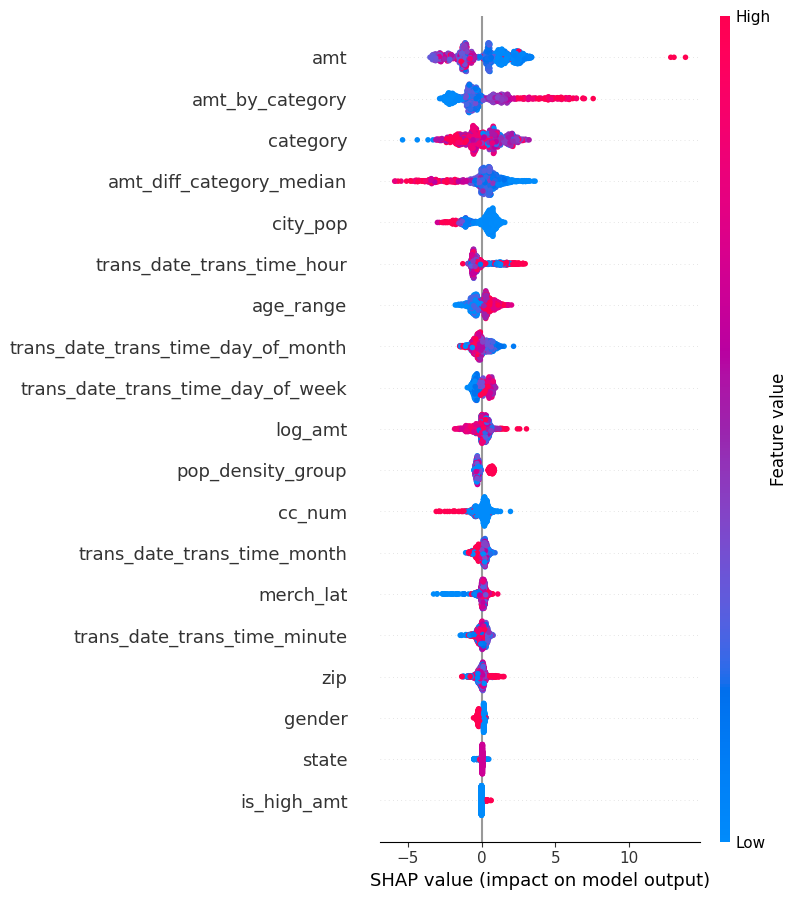

In [ ]:
# Visual SHAP summary
shap.summary_plot(shap_values, X_sample)

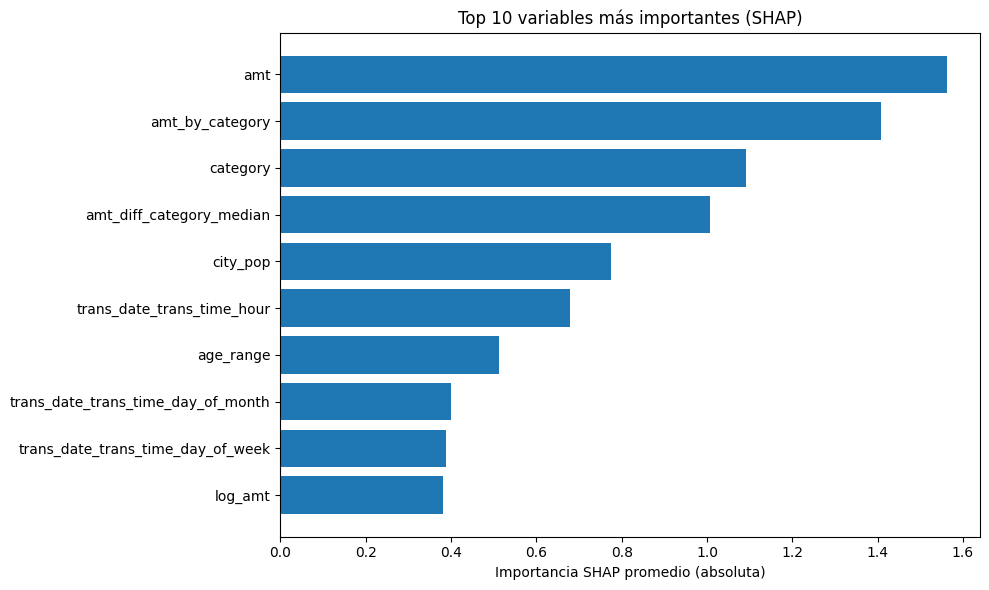

In [ ]:
# Top N features
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(shap_importance['feature'][:top_n][::-1], shap_importance['importance'][:top_n][::-1])
plt.xlabel('Mean Absolute SHAP Value')
plt.title(f'Top {top_n} Most Important Features (SHAP)')
plt.tight_layout()
plt.show()


- The SHAP summary plot provides clear evidence that amt, amt_by_category, and category are the most influential features in the model’s decision-making process. High transaction amounts, particularly when anomalous within their category, significantly increase the predicted probability of fraud. Temporal and demographic features such as transaction hour and city population also contribute meaningfully.

### Re-evaluate model performance

In [ ]:
results_shap  = train_evaluate_model(X_train_reduced, y_train, best_params)

print(f"PR-AUC promedio en TRAIN: {results_shap ['train_pr_auc']:.5f}")
print(f"PR-AUC promedio en VALIDACIÓN: {results_shap ['val_pr_auc']:.5f}")
print(f"F1-score promedio en TRAIN: {results_shap ['train_f1']:.5f}")
print(f"F1-score promedio en VALIDACIÓN: {results_shap ['val_f1']:.5f}")

PR-AUC promedio en TRAIN: 0.98059
PR-AUC promedio en VALIDACIÓN: 0.92136
F1-score promedio en TRAIN: 0.93869
F1-score promedio en VALIDACIÓN: 0.88820


- To improve interpretability and reduce dimensionality, SHAP values were computed. Features below the 25th percentile of importance were removed. This simplification preserved model performance, indicating that the remaining features retained most of the predictive power while enhancing model robustness

### Finds the optimal threshold

In [ ]:
def search_optimal_threshold_cv(X, y, model, precision_min=0.80, n_splits=5, sampler=None, train_func=None):
    thresholds = np.linspace(0.01, 0.99, 99)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    y_true_cv = []
    y_pred_cv = []
    optimal_thresholds = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Optional sampling (e.g., SMOTE)
        if sampler is not None:
            if len(X_tr) > 10000:
                X_tr_sample = X_tr.sample(10000, random_state=42)
                y_tr_sample = y_tr.loc[X_tr_sample.index]
            else:
                X_tr_sample, y_tr_sample = X_tr, y_tr

            X_tr, y_tr = sampler.fit_resample(X_tr_sample, y_tr_sample)

        # Train using custom function or default fit
        if train_func is not None:
            train_func(model, X_tr, y_tr, X_val, y_val)
        else:
            model.fit(X_tr, y_tr)

        y_proba = model.predict_proba(X_val)[:, 1]

        best_thresh = 0.5
        best_f2 = 0
        for t in thresholds:
            y_pred_thresh = (y_proba >= t).astype(int)
            precision, recall, _, _ = precision_recall_fscore_support(
                y_val, y_pred_thresh, average='binary', zero_division=0
            )
            f2 = 5 * (precision * recall) / (4 * precision + recall + 1e-10)
            if precision >= precision_min and f2 > best_f2:
                best_f2 = f2
                best_thresh = t

        print(f"Fold {fold}: Best threshold = {best_thresh:.2f} | F2 = {best_f2:.4f}")
        optimal_thresholds.append(best_thresh)

        y_pred_final = (y_proba >= best_thresh).astype(int)
        y_true_cv.extend(y_val)
        y_pred_cv.extend(y_pred_final)

    print("\nFinal Cross-Validated Classification Report:")
    print(classification_report(y_true_cv, y_pred_cv, digits=4))
    cm = confusion_matrix(y_true_cv, y_pred_cv)
    print("Final Confusion Matrix::")
    print(cm)
    print(f"\n Average Threshold Used: {np.mean(optimal_thresholds):.4f}")

    return {
        'y_true': y_true_cv,
        'y_pred': y_pred_cv,
        'threshold_avg': np.mean(optimal_thresholds),
        'conf_matrix': cm
    }


In [ ]:
# Training function for CatBoostClassifier with early stopping
def train_catboost(model, X_tr, y_tr, X_val, y_val):
    model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        use_best_model=True,
        early_stopping_rounds=50,
        verbose=0
    )


In [ ]:
# Base model initialization and evaluation using threshold search
model = CatBoostClassifier(**best_params, random_state=42)

res = search_optimal_threshold_cv(
    X_train_reduced, y_train,
    model,
    train_func=train_catboost
)


Fold 1: Best threshold = 0.09 | F2 = 0.8713
Fold 2: Best threshold = 0.11 | F2 = 0.8317
Fold 3: Best threshold = 0.12 | F2 = 0.8684
Fold 4: Best threshold = 0.20 | F2 = 0.8879
Fold 5: Best threshold = 0.19 | F2 = 0.8913

Final Cross-Validated Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9995    0.9995    387367
           1     0.8631    0.8717    0.8674      1497

    accuracy                         0.9990    388864
   macro avg     0.9313    0.9356    0.9334    388864
weighted avg     0.9990    0.9990    0.9990    388864

Final Confusion Matrix::
[[387160    207]
 [   192   1305]]

 Average Threshold Used: 0.1420


- A threshold optimization was performed using stratified cross-validation, prioritizing a minimum precision of 80%. This approach optimized the F2-score to reduce false negatives, which is crucial in fraud detection scenarios. The average optimal threshold was 0.1420, and the model achieved an excellent balance between precision (0.8631) and recall (0.8717) across all folds.

In [ ]:
# SMOTE Oversampling
model_smote = CatBoostClassifier(**best_params, random_state=42)
sampler_smote = SMOTE(random_state=42)

result_smote = search_optimal_threshold_cv(
    X_train_reduced, y_train,
    model_smote,
    sampler=sampler_smote,
    train_func=train_catboost
)

Fold 1: Best threshold = 0.43 | F2 = 0.7503
Fold 2: Best threshold = 0.50 | F2 = 0.7349
Fold 3: Best threshold = 0.76 | F2 = 0.7354
Fold 4: Best threshold = 0.35 | F2 = 0.7666
Fold 5: Best threshold = 0.32 | F2 = 0.7555

Final Cross-Validated Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9996    0.9993    387367
           1     0.8816    0.7214    0.7935      1497

    accuracy                         0.9986    388864
   macro avg     0.9403    0.8605    0.8964    388864
weighted avg     0.9985    0.9986    0.9985    388864

Final Confusion Matrix::
[[387222    145]
 [   417   1080]]

 Average Threshold Used: 0.4720


- SMOTE achieved good recall (72%) by oversampling the minority class. However, it sacrificed precision (88%) and increased false positives, which could lead to costly errors in sensitive domains like fraud detection.

In [ ]:
# SMOTEENN: Combined over/under-sampling
sampler_smoteenn = SMOTEENN(random_state=42)
model_smoteenn = CatBoostClassifier(**best_params, random_state=42)

result_smoteenn = search_optimal_threshold_cv(
    X_train_reduced, y_train,
    model_smoteenn,
    sampler=sampler_smoteenn,
    train_func=train_catboost
)

Fold 1: Best threshold = 0.48 | F2 = 0.7287
Fold 2: Best threshold = 0.39 | F2 = 0.7362
Fold 3: Best threshold = 0.68 | F2 = 0.7338
Fold 4: Best threshold = 0.24 | F2 = 0.7645
Fold 5: Best threshold = 0.37 | F2 = 0.7246

Final Cross-Validated Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9996    0.9992    387367
           1     0.8611    0.7121    0.7795      1497

    accuracy                         0.9984    388864
   macro avg     0.9300    0.8558    0.8894    388864
weighted avg     0.9984    0.9984    0.9984    388864

Final Confusion Matrix::
[[387195    172]
 [   431   1066]]

 Average Threshold Used: 0.4320


- SMOTEENN attempted to balance the dataset while removing noisy samples, but it further reduced precision and only maintained recall similar to SMOTE. The model showed less stability, with higher threshold variation across folds.

In [ ]:
# Stacking with CatBoost, XGBoost, LightGBM and RF
estimators = [
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('cat', CatBoostClassifier(**best_params, verbose=0, random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=CatBoostClassifier(**best_params, verbose=0, random_state=42),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

In [ ]:
result_stack = search_optimal_threshold_cv(
    X_train_reduced, y_train,
    model=stack_model
)

Fold 1: Best threshold = 0.13 | F2 = 0.8710
Fold 2: Best threshold = 0.11 | F2 = 0.8518
Fold 3: Best threshold = 0.09 | F2 = 0.8723
Fold 4: Best threshold = 0.55 | F2 = 0.8859
Fold 5: Best threshold = 0.24 | F2 = 0.8816

Final Cross-Validated Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9995    0.9995    387367
           1     0.8781    0.8711    0.8746      1497

    accuracy                         0.9990    388864
   macro avg     0.9388    0.9353    0.9370    388864
weighted avg     0.9990    0.9990    0.9990    388864

Final Confusion Matrix::
[[387186    181]
 [   193   1304]]

 Average Threshold Used: 0.2240


- The stacked model achieved the best balance: high precision (87%) and recall (87%), with the lowest error rate. Combining strong base models and using CatBoost as the final estimator allowed the ensemble to capture complex patterns effectively.

- The Stacking model was selected for delivering the best overall performance, consistently maintaining high precision and recall. This balance makes it robust for high-stakes tasks like fraud detection, where minimizing both false negatives and false positives is essential.

In [ ]:
# Comparison table of model performance
df_comparacion = pd.DataFrame({
    'Model': [
        'CatBoost',
        'CatBoost + SMOTE',
        'CatBoost + SMOTEENN',
        'Stacking (mejor)'
    ],
    'Threshold': [0.1420, 0.4720, 0.4320, 0.2240],
    'Precision': [0.8631, 0.8816, 0.8611, 0.8781],
    'Recall': [0.8717, 0.7214, 0.7121, 0.8711],
    'F1-score': [0.8674, 0.7935, 0.7795 , 0.8746],
    'False Negatives (FN)': [192, 417, 431, 193],
    'False Positives (FP)': [207, 145, 172, 181]
})

# Sort table by Recall descending for analysis
df_comparison_sorted = df_comparacion.sort_values(by='Recall', ascending=False).reset_index(drop=True)

# Display formatted table (Google Colab or Jupyter)
display(df_comparison_sorted)

,Modelo,Threshold,Precision,Recall,F1-score,False Negatives (FN),False Positives (FP)
0,CatBoost,0.142,0.8631,0.8717,0.8674,192,207
1,Stacking (mejor),0.224,0.8781,0.8711,0.8746,193,181
2,CatBoost + SMOTE,0.472,0.8816,0.7214,0.7935,417,145
3,CatBoost + SMOTEENN,0.432,0.8611,0.7121,0.7795,431,172


### Visual comparison of model metrics (Precision, Recall, F1-score)

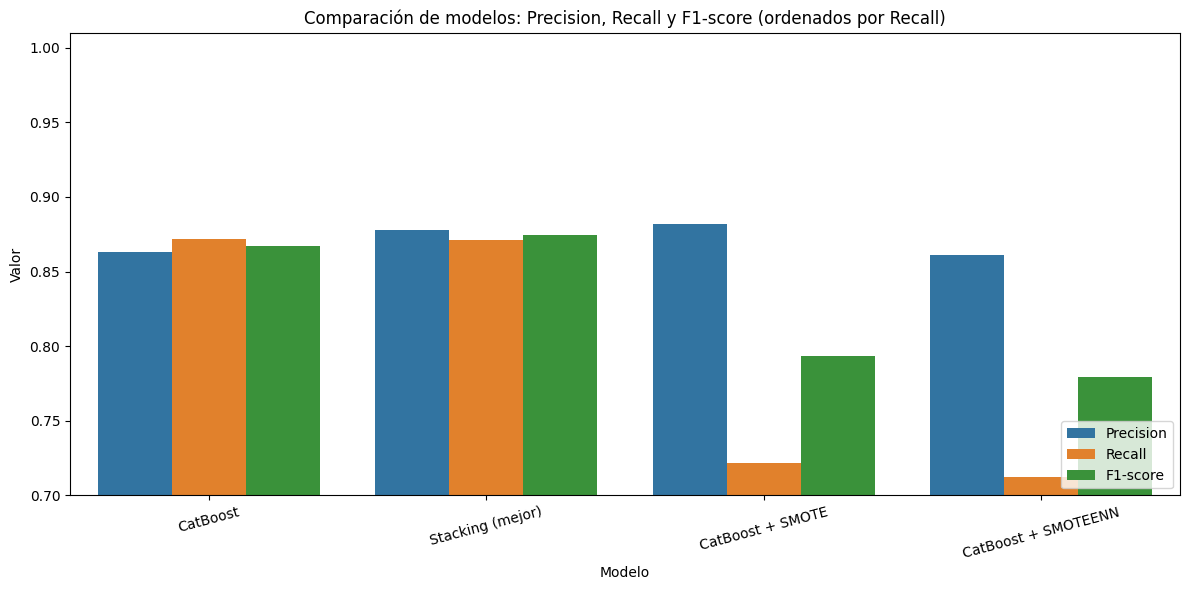

In [ ]:
# Sort models by Recall (highest to lowest)
df_ordenado = df_comparacion.sort_values(by='Recall', ascending=False).reset_index(drop=True)

# Melt dataframe to plot grouped bars in seaborn
df_plot = df_sorted.melt(
    id_vars='Model',
    value_vars=['Precision', 'Recall', 'F1-score'],
    var_name='Metric',
    value_name='Score'
)

# Get model display order based on Recall
model_order = df_sorted['Model'].tolist()

# Create the grouped barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x='Model', y='Score', hue='Metric', order=model_order)
plt.title("Model Comparison: Precision, Recall & F1-score")
plt.ylim(0.7, 1.01)
plt.xticks(rotation=15)
plt.legend(title='Metric', loc='lower right')
plt.tight_layout()
plt.show()


- Clearly visualizes each model’s relative performance on key metrics, sorted by Recall to facilitate comparison of positive detection capability. Quickly identifies the best balanced model

## Function to evaluate metrics on the validation set

In [ ]:
# Evaluate the model using a custom threshold
def evaluate_model_on_validation(model, X_val, y_val, threshold):

    """
    Evaluate a trained model on the validation set using a custom threshold.
    """
    y_proba_val = model.predict_proba(X_val_reduced)[:, 1]
    y_pred_val = (y_proba_val >= threshold).astype(int)

    print("\nValidation Set Evaluation:")
    print(classification_report(y_val, y_pred_val, digits=4))

    cm = confusion_matrix(y_val, y_pred_val)
    print("Confusion Matrix:")
    print(cm)

    return y_pred_val, cm


- Allows evaluation of a trained model on a separate validation set using a custom threshold to convert probabilities into binary predictions, displaying detailed metrics and confusion matrix.

In [ ]:
# List of trained models and their optimal thresholds
models_to_validate = [
    {
        'name': 'CatBoost baseline',
        'model': model,
        'threshold': 0.142
    },
    {
        'name': 'CatBoost + SMOTE',
        'model': model_smote,
        'threshold': 0.472
    },
    {
        'name': 'CatBoost + SMOTEENN',
        'model': model_smoteenn,
        'threshold': 0.432
    },
    {
        'name': 'Stacking Model',
        'model': stack_model,
        'threshold': 0.224
    },
]

for i, m in enumerate(models_to_validate, 1):
    print(f"\n=== Evaluating Model {i}: {m['name']} ===")
    y_pred, cm = evaluar_modelo_entrenado(
        m['model'],
        X_val_reduced,
        y_val,
        m['threshold']
    )



=== Evaluando Modelo 1: CatBoost baseline ===

📊 Evaluación en VAL_HOLDOUT:
              precision    recall  f1-score   support

           0     0.9994    0.9989    0.9991     83007
           1     0.7445    0.8442    0.7912       321

    accuracy                         0.9983     83328
   macro avg     0.8720    0.9216    0.8952     83328
weighted avg     0.9984    0.9983    0.9983     83328

📌 Matriz de confusión:
[[82914    93]
 [   50   271]]

=== Evaluando Modelo 2: CatBoost + SMOTE ===

📊 Evaluación en VAL_HOLDOUT:
              precision    recall  f1-score   support

           0     0.9992    0.9923    0.9957     83007
           1     0.2827    0.7882    0.4161       321

    accuracy                         0.9915     83328
   macro avg     0.6409    0.8902    0.7059     83328
weighted avg     0.9964    0.9915    0.9935     83328

📌 Matriz de confusión:
[[82365   642]
 [   68   253]]

=== Evaluando Modelo 3: CatBoost + SMOTEENN ===

📊 Evaluación en VAL_HOLDOUT:
      

- Integrated evaluation and visualization show the stacking model maintains the best balance of precision and recall on validation, confirming its robustness and recommendation for production.

## Evaluation with test set

📊 Métricas en TEST con umbral 0.224:
Precision: 0.8312
Recall:    0.8156
F1-score:  0.8233
F2-score:  0.8187
PR-AUC:    0.8625

Reporte de clasificación completo:
              precision    recall  f1-score   support

           0     0.9993    0.9994    0.9993     83008
           1     0.8312    0.8156    0.8233       320

    accuracy                         0.9987     83328
   macro avg     0.9152    0.9075    0.9113     83328
weighted avg     0.9986    0.9987    0.9986     83328



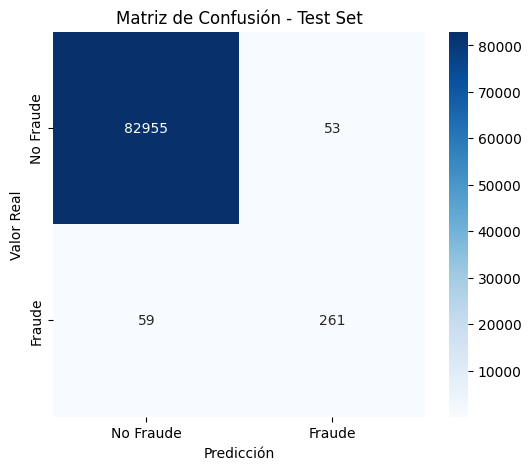

In [ ]:
# Optimal threshold previously found during cross-validation
optimal_threshold = 0.224

# Predict class probabilities with the final model
y_proba_test = stack_model.predict_proba(X_test_reduced)[:, 1]

# Apply threshold to convert probabilities to class labels
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)

# Calculate standard classification metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
f2 = 5 * (precision * recall) / (4 * precision + recall + 1e-10)

# Compute PR curve and AUC (area under the curve)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_test)
pr_auc = auc(recall_curve, precision_curve)

# Print main metrics
print(f"Metrics on TEST SET with threshold {optimal_threshold}:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"F2-score:  {f2:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}\n")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_test, digits=4))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Fraud', 'Fraud'],
    yticklabels=['No Fraud', 'Fraud']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()


- The model correctly identifies most fraudulent transactions (**261 out of 320**), proving its reliability in real fraud detection.  
- Only **59 frauds** were missed (false negatives), a small number that helps reduce potential losses.  
- It also maintains **high precision**, with just **53 false positives**, avoiding unnecessary alerts and reducing operational costs.  
- The **custom threshold (0.224)** was selected to prioritize fraud detection (Recall) without sacrificing too much precision.  
- Furthermore, the **PR-AUC of 86.2%** confirms the model performs robustly even with severe class imbalance.

## Final Project Conclusion

This credit card fraud detection project successfully developed a highly accurate and reliable model, even under severe class imbalance.  
By combining advanced techniques such as **stratified cross-validation**, **threshold optimization**, **resampling (SMOTE/SMOTEENN)**, **ensemble learning (Stacking)**, and evaluation with **PR-AUC**, the final model shows a strong balance between **recall** and **precision**, minimizing the most critical errors (FN and FP).  
This approach enables **maximum fraud detection without unfairly penalizing legitimate users**, making it a practical, ethical, and production-ready solution.